In [1]:
#packages import
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.subplots import make_subplots

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans,AgglomerativeClustering
from sklearn.model_selection import cross_validate, GridSearchCV, learning_curve,train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score
import plotly.graph_objs as go
from statsmodels.tsa.api import ExponentialSmoothing
import statsmodels.api as sm
from scipy import stats

import os
import glob

## 1. 数据概览

In [2]:
filePath = '../input/beijing-multisite-airquality-data-set'
allFiles = glob.glob(filePath + "/*.csv")
dataFrames = []
for i in allFiles:
    df = pd.read_csv(i, index_col=None, header=0)
    dataFrames.append(df)
data = pd.concat(dataFrames)
data.head(5)

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
0,1,2013,3,1,0,4.0,4.0,14.0,20.0,300.0,69.0,-0.7,1023.0,-18.8,0.0,NNW,4.4,Guanyuan
1,2,2013,3,1,1,4.0,4.0,13.0,17.0,300.0,72.0,-1.1,1023.2,-18.2,0.0,N,4.7,Guanyuan
2,3,2013,3,1,2,3.0,3.0,10.0,19.0,300.0,69.0,-1.1,1023.5,-18.2,0.0,NNW,5.6,Guanyuan
3,4,2013,3,1,3,3.0,6.0,7.0,24.0,400.0,62.0,-1.4,1024.5,-19.4,0.0,NW,3.1,Guanyuan
4,5,2013,3,1,4,3.0,6.0,5.0,14.0,400.0,71.0,-2.0,1025.2,-19.5,0.0,N,2.0,Guanyuan


### 类别名称及其意思
Attribute Information:

No: row number

year: year of data in this row

month: month of data in this row

day: day of data in this row

hour: hour of data in this row

PM2.5: PM2.5 concentration (ug/m^3)

PM10: PM10 concentration (ug/m^3)

SO2: SO2 concentration (ug/m^3)

NO2: NO2 concentration (ug/m^3)

CO: CO concentration (ug/m^3)

O3: O3 concentration (ug/m^3)

TEMP: temperature (degree Celsius)

PRES: pressure (hPa)

DEWP: dew point temperature (degree Celsius)

RAIN: precipitation (mm)

wd: wind direction

WSPM: wind speed (m/s)

station: name of the air-quality monitoring site

In [3]:
data.shape

(420768, 18)

In [4]:
data.describe()

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM
count,420768.000000,420768.000000,420768.000000,420768.000000,420768.000000,412029.000000,414319.000000,411747.000000,408652.000000,400067.000000,407491.000000,420370.000000,420375.000000,420365.000000,420378.000000,420450.000000
mean,17532.500000,2014.662560,6.522930,15.729637,11.500000,79.793428,104.602618,15.830835,50.638586,1230.766454,57.372271,13.538976,1010.746982,2.490822,0.064476,1.729711
std,10122.116943,1.177198,3.448707,8.800102,6.922195,80.822391,91.772426,21.650603,35.127912,1160.182716,56.661607,11.436139,10.474055,13.793847,0.821004,1.246386
min,1.000000,2013.000000,1.000000,1.000000,0.000000,2.000000,2.000000,0.285600,1.026500,100.000000,0.214200,-19.900000,982.400000,-43.400000,0.000000,0.000000
25%,8766.750000,2014.000000,4.000000,8.000000,5.750000,20.000000,36.000000,3.000000,23.000000,500.000000,11.000000,3.100000,1002.300000,-8.900000,0.000000,0.900000
50%,17532.500000,2015.000000,7.000000,16.000000,11.500000,55.000000,82.000000,7.000000,43.000000,900.000000,45.000000,14.500000,1010.400000,3.100000,0.000000,1.400000
75%,26298.250000,2016.000000,10.000000,23.000000,17.250000,111.000000,145.000000,20.000000,71.000000,1500.000000,82.000000,23.300000,1019.000000,15.100000,0.000000,2.200000
max,35064.000000,2017.000000,12.000000,31.000000,23.000000,999.000000,999.000000,500.000000,290.000000,10000.000000,1071.000000,41.600000,1042.800000,29.100000,72.500000,13.200000


### 缺失值及其处理

In [5]:
pd.DataFrame(data = data.isna().sum()/data.shape[0]*100, columns=["Null (%)"]).style.background_gradient(cmap='summer_r')

,Null (%)
No,0.000000
year,0.000000
month,0.000000
day,0.000000
hour,0.000000
PM2.5,2.076916
PM10,1.532674
SO2,2.143937
NO2,2.879497
CO,4.919813


论述缺失值，其来源、所有处理方法以及如何选择。不能drop，因为会破坏时间序列的结构。

In [6]:
data.drop('wd', axis = 1, inplace = True)

In [7]:
#上下两个值的平均值进行填充
data = data.fillna(data.interpolate('nearest'))
#在此详细介绍下interpolate函数的参数：'nearest', 'zero', 'slinear', 'quadratic', 'cubic', 'spline', 'barycentric', 'polynomial'

### 相关性探索

In [8]:
var = ['PM2.5', 'PM10', 'SO2', 'NO2','CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'WSPM', 'RAIN']
for i in var:
    print(i, stats.kstest(data[i], 'norm', (data[i].mean(), data[i].std())))

PM2.5 KstestResult(statistic=0.17127724916109516, pvalue=0.0)
PM10 KstestResult(statistic=0.1375870994087107, pvalue=0.0)
SO2 KstestResult(statistic=0.252796007552042, pvalue=0.0)
NO2 KstestResult(statistic=0.08918096994237545, pvalue=0.0)
CO KstestResult(statistic=0.18187727611825455, pvalue=0.0)
O3 KstestResult(statistic=0.1596998224514083, pvalue=0.0)
TEMP KstestResult(statistic=0.07430464867822983, pvalue=0.0)
PRES KstestResult(statistic=0.047243036619055934, pvalue=0.0)
DEWP KstestResult(statistic=0.08956263252355401, pvalue=0.0)
WSPM KstestResult(statistic=0.14157157131335524, pvalue=0.0)
RAIN KstestResult(statistic=0.4920177169493985, pvalue=0.0)


都不符合正态分布， 所以采用Spearman相关系数。

In [9]:
fig = px.imshow(data.iloc[:,5:].corr(method='spearman') ,text_auto=True, aspect="auto" , color_continuous_scale = "viridis")
fig.show()

### 画图概览

#### 1. 月份变化

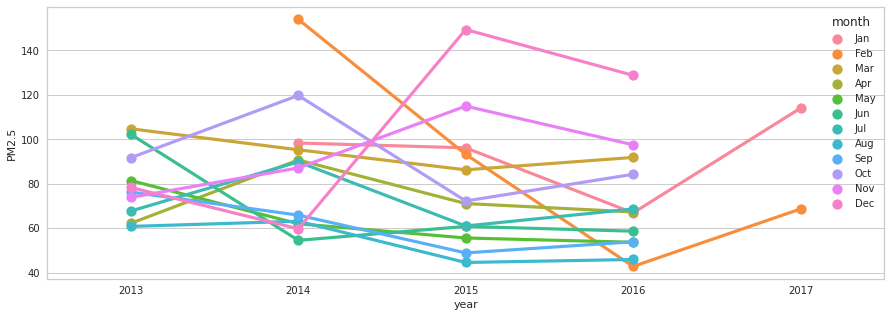

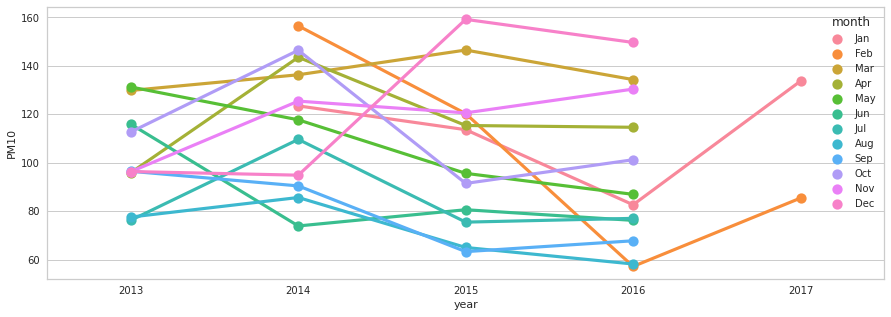

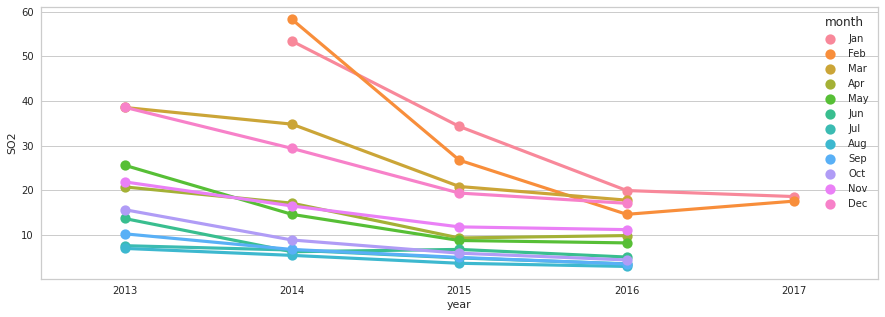

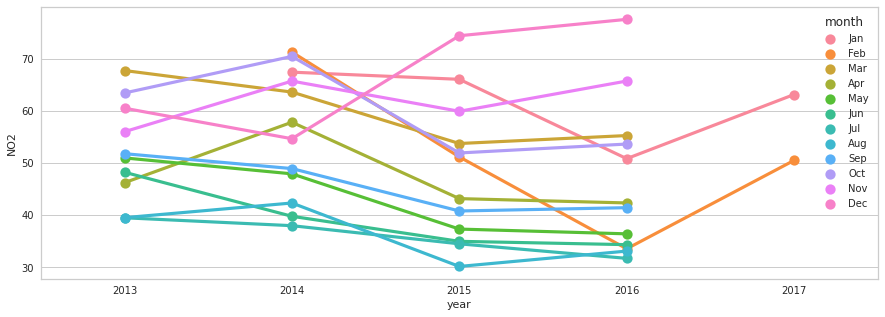

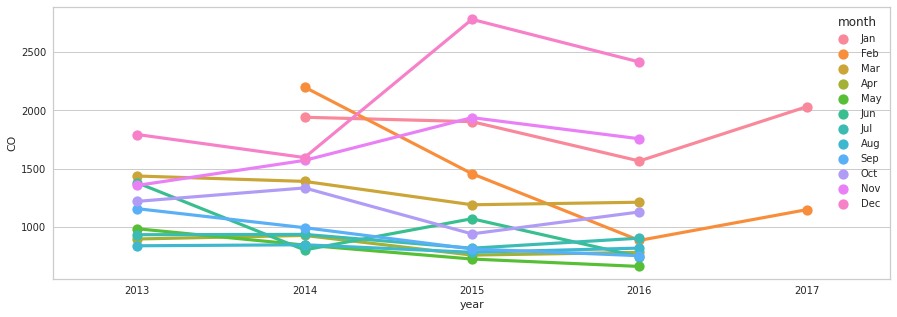

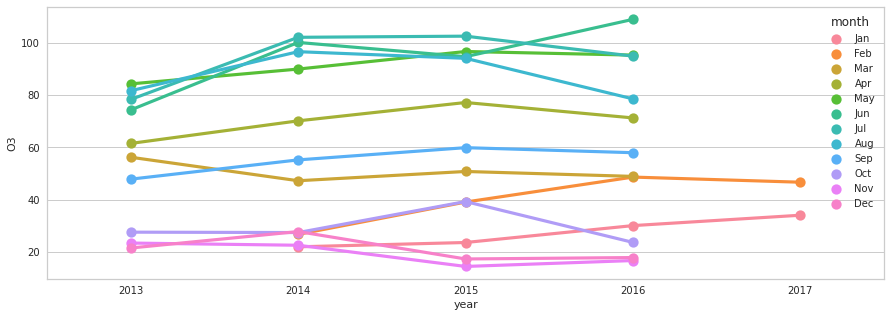

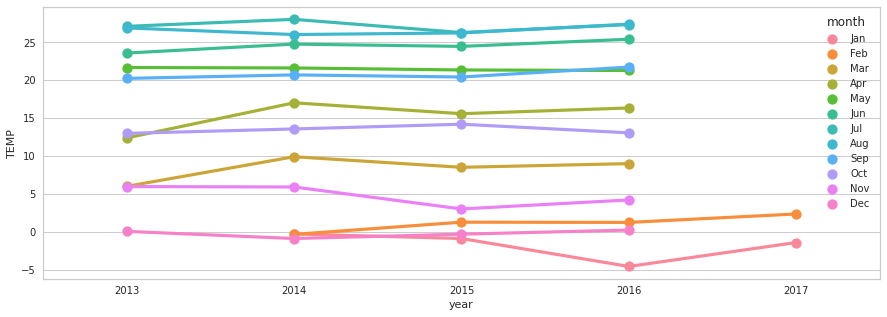

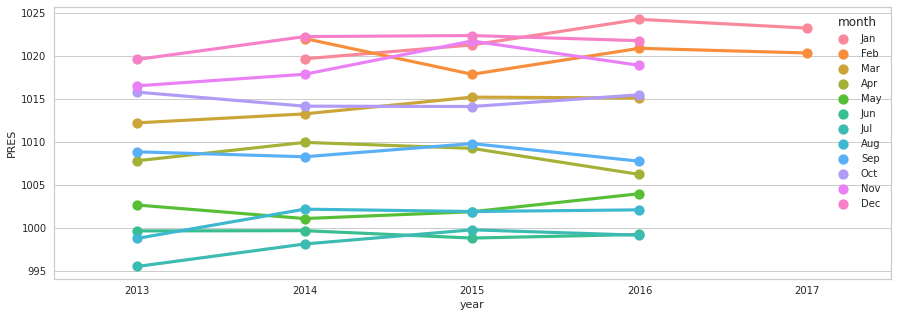

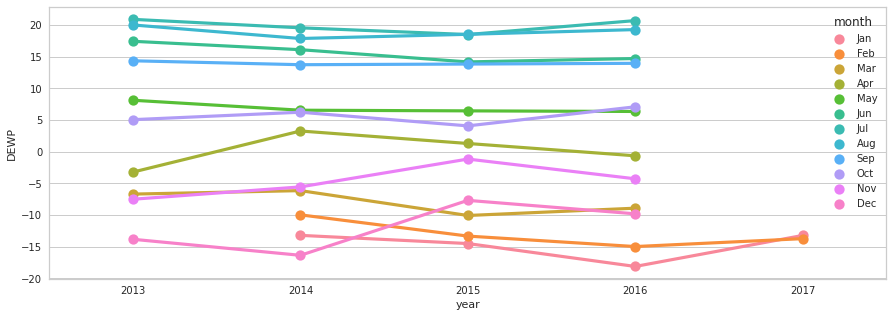

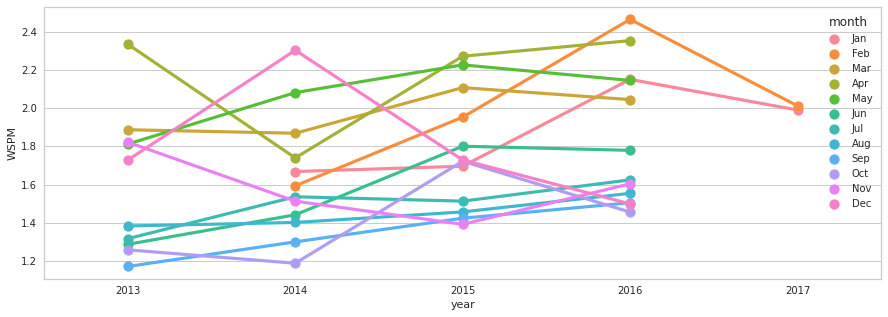

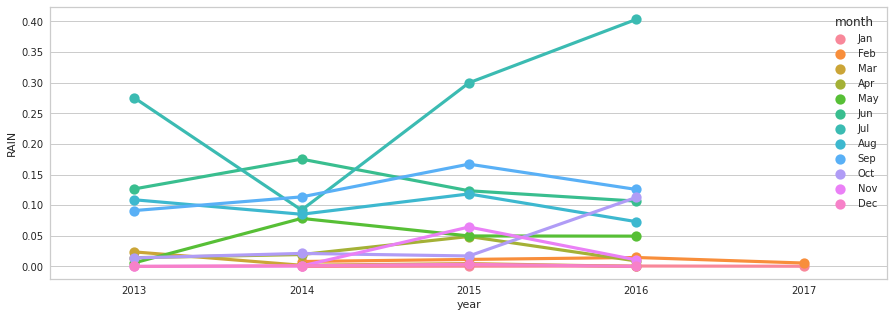

In [10]:
for i in var:
    temp_data = data.copy()
    temp_data.month.replace([1,2,3,4,5,6,7,8,9,10,11,12], ['Jan', 'Feb', 'Mar', 'Apr', 'May', 
                                                           'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], inplace=True)
    df = temp_data[[i, 'month', 'year',]].groupby(["year",
                                                    "month"]).mean().reset_index().sort_values(by=['year',                                                                                              'month'], ascending=False)
    f, ax=plt.subplots(figsize=(15, 5))
    sns.pointplot(x='year', y=i, data=df, hue='month', hue_order=['Jan', 'Feb', 'Mar', 'Apr', 'May', 
                                                                  'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])


#### 2. 年份变化

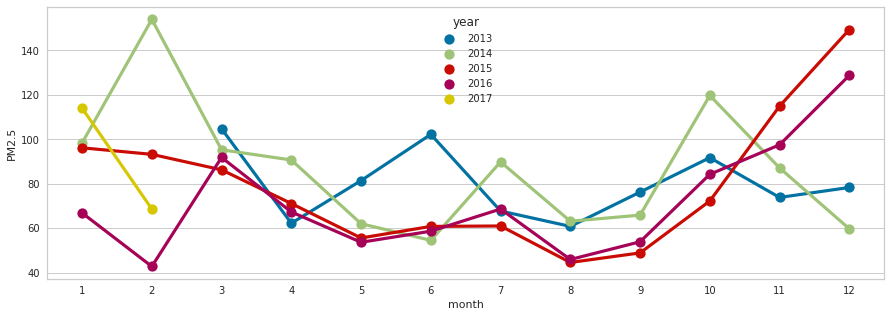

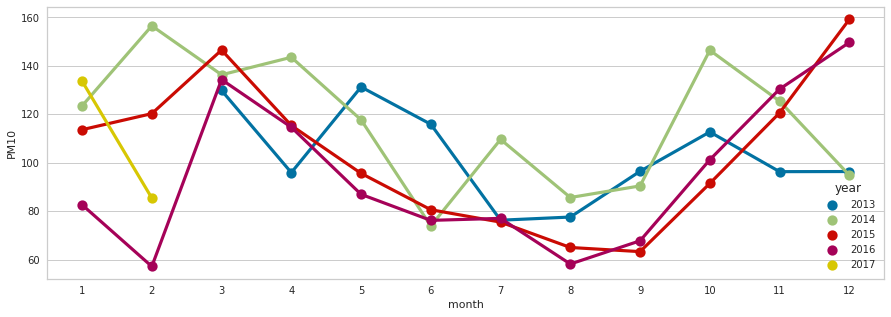

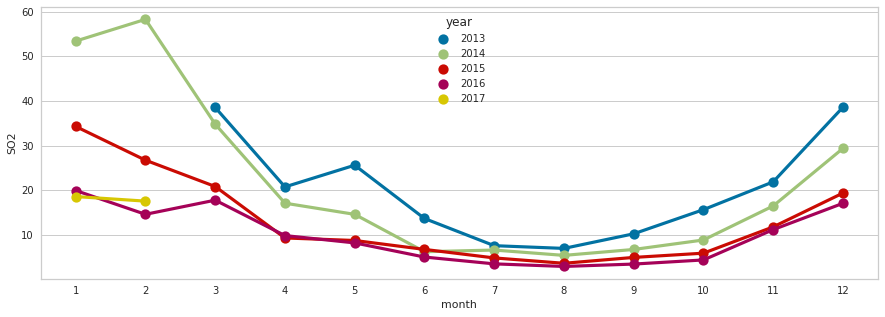

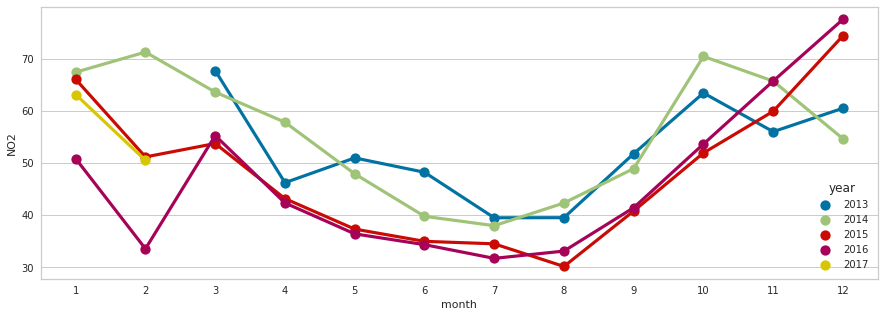

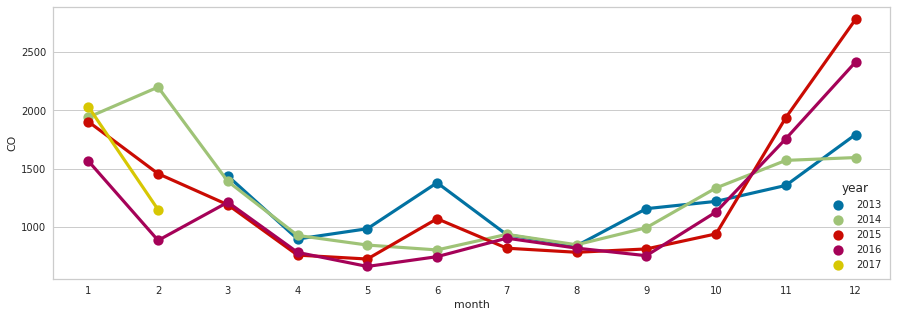

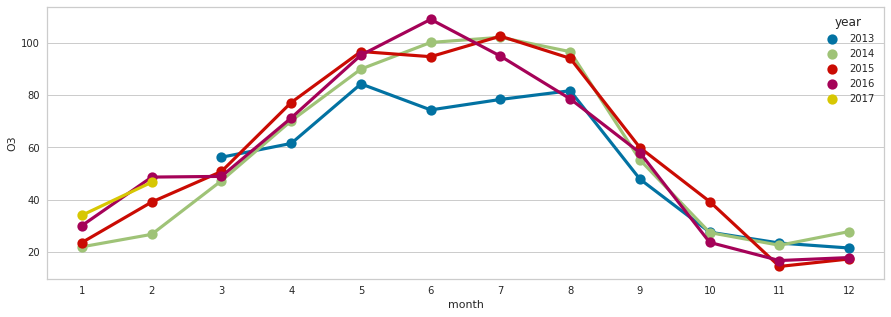

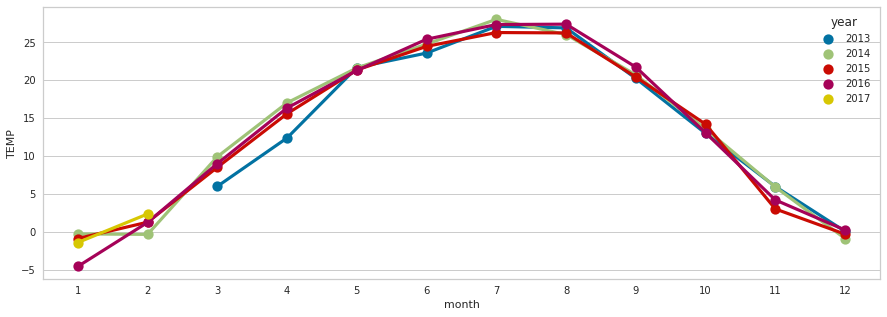

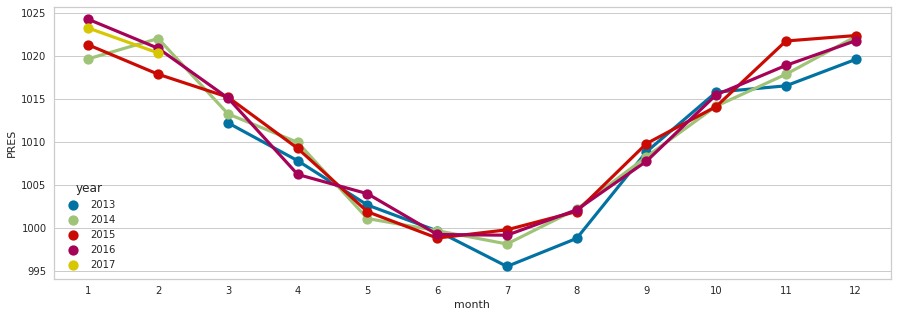

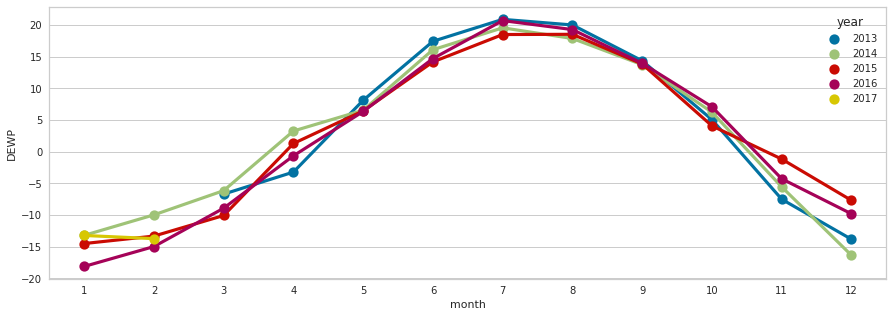

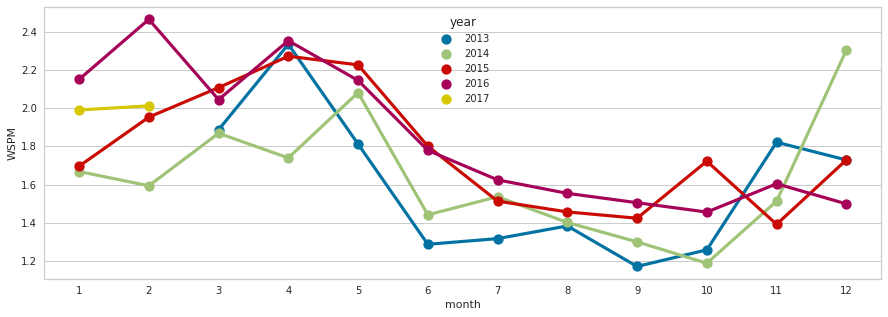

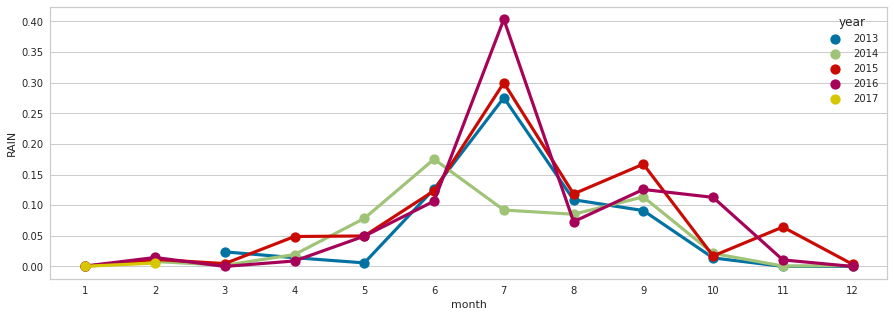

In [11]:
for i in var:    
    temp_data = data.copy()
    df = temp_data[[i, 'month', 'year']].groupby(["year",
                                                  "month"]).mean().reset_index().sort_values(by=['year', 'month'], ascending=True)
    f, ax=plt.subplots(figsize=(15, 5))
    sns.pointplot(x='month', y=i, data=df, hue="year")

#### 3. 污染物的地区分布

In [12]:
pollution = data[['PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3', 'station']]
pollution.groupby('station', as_index = False).mean()

,station,PM2.5,PM10,SO2,NO2,CO,O3
0,Aotizhongxin,82.642177,109.996429,17.631407,59.546598,1275.569701,55.140725
1,Changping,71.682814,95.187979,14.957853,44.337528,1161.324179,57.933483
2,Dingling,66.417862,84.356947,11.923524,28.240877,929.334902,68.441722
3,Dongsi,86.196444,110.401663,18.502547,54.105735,1322.944501,57.525014
4,Guanyuan,82.958579,109.113470,17.617164,58.022225,1271.397131,54.762404
5,Gucheng,84.210564,119.120283,15.454239,56.061314,1326.837469,57.459617
6,Huairou,69.731511,92.102011,12.347236,33.317765,1025.660364,59.824251
7,Nongzhanguan,84.818731,109.207829,18.744289,58.165681,1328.229495,58.413278
8,Shunyi,79.401991,99.112389,13.612418,44.458380,1179.742157,55.013219
9,Tiantan,82.129415,106.626634,14.622643,53.348936,1304.186915,55.775244


## 2. 标准化，训练集、测试集分割

将2017年的数据作为测试集，尝试预测补全2017年的PM2.5、PM10数据

In [13]:
sd = StandardScaler()
sd_data = data.copy()
sd_data[var] = sd.fit_transform(sd_data[var])

In [14]:
train_data = sd_data[sd_data['year'] != 2017]
test_data = sd_data[sd_data['year'] == 2017]

## 3. 聚类分析

### (1) PCA主成分提取

In [15]:
pca_data = sd_data.drop('hour', axis = 1).drop_duplicates(subset = ['year','month','day','station'], keep = 'first')
PCA_data = data.drop('hour', axis = 1).drop_duplicates(subset = ['year','month','day','station'], keep = 'first')
pca = PCA(n_components = pca_data[var].shape[1])
pca.fit(pca_data[var])
print ('所保留的n个成分各自的方差百分比:',pca.explained_variance_ratio_ )
print ('所保留的n个成分各自的方差值:',pca.explained_variance_  )

所保留的n个成分各自的方差百分比: [0.43170638 0.23936251 0.08119051 0.07302342 0.05287543 0.03890318
 0.02919175 0.0213948  0.01773439 0.01023704 0.0043806 ]
所保留的n个成分各自的方差值: [4.54274414 2.51875509 0.85434852 0.76840812 0.55639564 0.409369
 0.30717786 0.22513238 0.18661476 0.10772194 0.04609597]


**所以我们选择k=3**

In [16]:
pca = PCA(n_components = 3)
PCA_ds = pd.DataFrame(pca.fit_transform(pca_data[var]), columns=(["col1","col2", "col3"]))
PCA_ds.describe().T

,count,mean,std,min,25%,50%,75%,max
col1,17532.0,-6.484533e-18,2.131371,-4.172986,-1.477884,-0.635676,0.919955,13.318240
col2,17532.0,-2.999097e-17,1.587059,-5.243055,-1.280578,-0.252401,1.193599,5.307610
col3,17532.0,1.296907e-17,0.924310,-2.472483,-0.619778,-0.107018,0.483946,9.589203


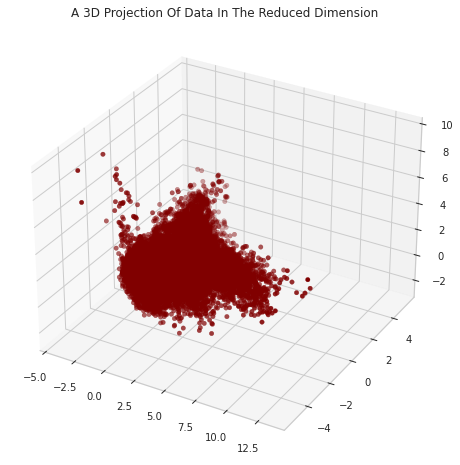

In [17]:
x = PCA_ds["col1"]
y = PCA_ds["col2"]
z = PCA_ds["col3"]
#To plot
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(x,y,z, c = "maroon", marker = "o" )
ax.set_title("A 3D Projection Of Data In The Reduced Dimension")
plt.show()

### (2) 聚类

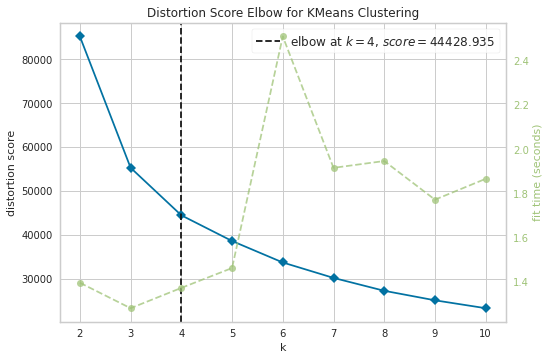

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [18]:
Elbow_M = KElbowVisualizer(KMeans(), k=10)
Elbow_M.fit(PCA_ds)
Elbow_M.show()

In [19]:
AC = AgglomerativeClustering(n_clusters = 4)
yhat_AC = AC.fit_predict(PCA_ds)
PCA_ds["Clusters"] = yhat_AC
pca_data["Clusters"] = yhat_AC
PCA_data["Clusters"] = yhat_AC

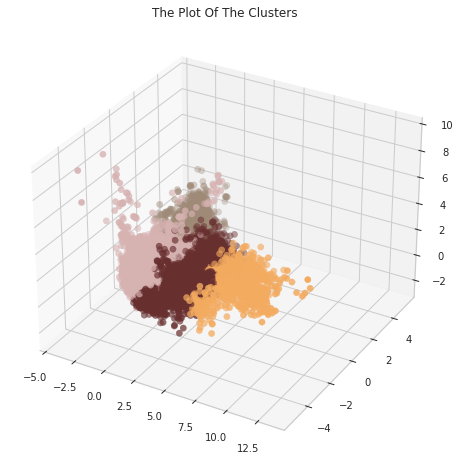

In [20]:
from matplotlib import colors
cam = colors.ListedColormap(["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"])
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, projection='3d', label="bla")
ax.scatter(x, y, z, s = 40, c = PCA_ds["Clusters"], marker='o', cmap = cam)
ax.set_title("The Plot Of The Clusters")
plt.show()

### (3) 聚类结果解释

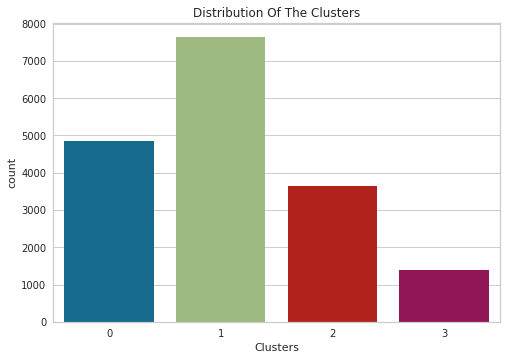

In [21]:
pl = sns.countplot(x = pca_data["Clusters"])
pl.set_title("Distribution Of The Clusters")
plt.show()

In [22]:
PCA_data

,No,year,month,day,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM,station,Clusters
0,1,2013,3,1,4.0,4.0,14.0,20.0,300.0,69.0,-0.7,1023.0,-18.8,0.0,4.4,Guanyuan,2
24,25,2013,3,2,6.0,15.0,16.0,44.0,500.0,46.0,-0.4,1031.0,-17.6,0.0,1.4,Guanyuan,2
48,49,2013,3,3,77.0,93.0,69.0,106.0,1899.0,2.0,-1.4,1020.4,-13.0,0.0,1.2,Guanyuan,0
72,73,2013,3,4,28.0,48.0,22.0,94.0,1700.0,2.0,7.7,1015.7,-11.1,0.0,2.6,Guanyuan,0
96,97,2013,3,5,70.0,102.0,57.0,90.0,1200.0,95.0,4.7,1015.2,-9.1,0.0,1.6,Guanyuan,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34944,34945,2017,2,24,55.0,92.0,21.0,59.0,100.0,22.0,0.7,1022.2,-9.9,0.0,0.8,Dongsi,2
34968,34969,2017,2,25,10.0,25.0,7.0,56.0,800.0,23.0,5.9,1021.0,-11.7,0.0,1.6,Dongsi,2
34992,34993,2017,2,26,18.0,31.0,8.0,56.0,600.0,35.0,4.2,1020.7,-8.6,0.0,1.0,Dongsi,2
35016,35017,2017,2,27,52.0,79.0,16.0,62.0,900.0,20.0,5.4,1020.0,-7.8,0.0,0.9,Dongsi,0


In [23]:
cluster = PCA_data.groupby(['station', 'year', 'month', 'Clusters'], as_index = True)['Clusters'].count()
cluster = pd.DataFrame(cluster)
cluster.columns = ['count']
cluster = cluster.reset_index()
cluster = cluster.groupby(['station', 'year', 'month'], as_index = False)['count','Clusters'].max()
cluster.drop('count', axis = 1, inplace = True)
dic = {
    1:'Winter',
    2:'Winter',
    3:'Spring',
    4:'Spring',
    5:'Spring',
    6:'Summer',
    7:'Summer',
    8:'Summer',
    9:'Fall',
    10:'Fall',
    11:'Fall',
    12:'Winter'
}
cluster['Season'] = cluster['month'].map(dic)
cluster = cluster.groupby(['station', 'Season','Clusters'])['Clusters'].count()
cluster = pd.DataFrame(cluster)
cluster.columns = ['count']
cluster = cluster.reset_index()
cluster = cluster.groupby(['station', 'Season'], as_index = False)['count','Clusters'].max()
cluster.drop('count', axis = 1, inplace = True)
cluster

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:26: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



,station,Season,Clusters
0,Aotizhongxin,Fall,3
1,Aotizhongxin,Spring,3
2,Aotizhongxin,Summer,1
3,Aotizhongxin,Winter,3
4,Changping,Fall,3
5,Changping,Spring,3
6,Changping,Summer,1
7,Changping,Winter,3
8,Dingling,Fall,3
9,Dingling,Spring,3


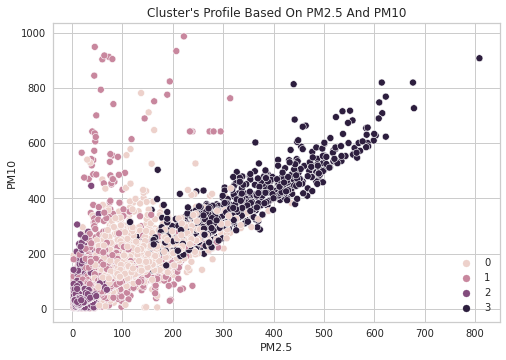

In [24]:
pl = sns.scatterplot(data = PCA_data,x = PCA_data["PM2.5"], y = PCA_data["PM10"], hue = PCA_data["Clusters"])
pl.set_title("Cluster's Profile Based On PM2.5 And PM10")
plt.legend()
plt.show()

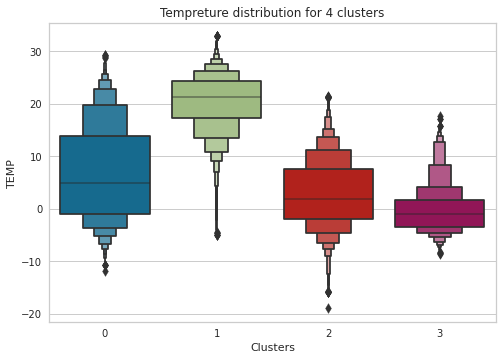

In [25]:
plt.figure()
pl=sns.boxenplot(y = PCA_data["TEMP"],x = PCA_data["Clusters"])
pl.set_title("Tempreture distribution for 4 clusters")
plt.show()

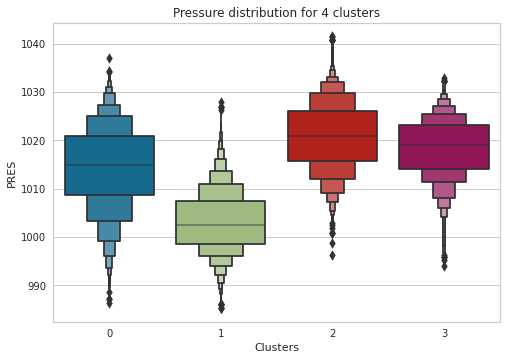

In [26]:
plt.figure()
pl = sns.boxenplot(y = PCA_data["PRES"],x = PCA_data["Clusters"])
pl.set_title("Pressure distribution for 4 clusters")
plt.show()

温度和压强负相关

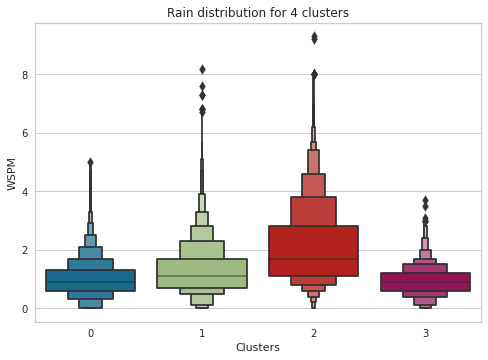

In [27]:
plt.figure()
pl = sns.boxenplot(y = PCA_data["WSPM"],x = PCA_data["Clusters"])
pl.set_title("Rain distribution for 4 clusters")
plt.show()

## 4.模型预测模拟

### (1)通过其他参数预测PM2.5和PM10

#### a. PM2.5

In [28]:
X = train_data[var[2:]]
Y0 = train_data[var[0]]
Y1 = train_data[var[1]]
X_train, X_test, Y0_train, Y0_test = train_test_split(X, Y0, test_size=0.1, random_state=1)
X_train1, X_test1, Y1_train, Y1_test = train_test_split(X, Y1, test_size=0.1, random_state=1)

In [29]:
seed = 1
classifiers = {
    'Linear': LinearRegression(),
    "KNN": KNeighborsRegressor(), 
    "DT": DecisionTreeRegressor(),
    "RF": RandomForestRegressor(),
    "XGB": XGBRegressor()
}


fig = make_subplots(rows=5, cols=1,shared_xaxes=True,subplot_titles=('Linear','KNN','DecisionTree','RandomForest','XGBooster'))
results = pd.DataFrame(columns=["Classifier"])
results1 = pd.DataFrame(columns=["Classifier"])
i = 1
for name, clf in classifiers.items():
    model = clf
    cv_results = cross_validate(
        model, X_train, Y0_train, cv=5,
        scoring=(['neg_mean_squared_error'])
    )
    cv_results1 = cross_validate(
        model, X_train1, Y1_train, cv=5,
        scoring=(['neg_mean_squared_error'])
    )
    y = cv_results['test_neg_mean_squared_error']
    y1 = cv_results1['test_neg_mean_squared_error']
    fig.add_trace(
    go.Scatter(x=list(range(0,cv_results['test_neg_mean_squared_error'].shape[0])),y=y,name= name),
    row=i, col=1
    ) 
    results = results.append({
        "Classifier": name,
        "Avg_Accuracy": cv_results['test_neg_mean_squared_error'].mean()
    }, ignore_index=True)
    results1 = results1.append({
        "Classifier": name,
        "Avg_Accuracy": cv_results1['test_neg_mean_squared_error'].mean()
    }, ignore_index=True)
    i +=1
print(results)

KeyboardInterrupt: 

In [ ]:
print(results1)

In [ ]:
fig.update_layout(height=800, width=900, title_text="Different Model 5 Fold Cross Validation")
fig.update_yaxes(title_text="Accuracy")
fig.update_xaxes(title_text="Fold")
fig.show()

所以我们采用随机森林算法进行模拟和预测。

In [30]:
RF = RandomForestRegressor(random_state = seed, n_jobs = -1)
RF1 = RF.fit(X_train, Y0_train)
RF1.score(X_test, Y0_test)

0.87272862091363

In [31]:
fig = go.Figure()
fig.add_trace(go.Bar(x=X_train.columns,y=RF1.feature_importances_))
fig.update_layout(title='The Importance Of The Original Attributes in PM2.5',xaxis_title='Model',yaxis_title='F1 Score')
fig.show()

In [32]:
RF2 = RF.fit(X_train1, Y1_train)
RF2.score(X_test1, Y1_test)

0.7959293423003531

In [33]:
fig = go.Figure()
fig.add_trace(go.Bar(x=X_train.columns,y=RF2.feature_importances_))
fig.update_layout(title='The Importance Of The Original Attributes in PM10',xaxis_title='Model',yaxis_title='F1 Score')
fig.show()

### (2) 时序模型模拟

使用时序模型，模拟除了PM2.5和PM10以外的变量的变化情况。

注意采用的是中心化之前的数据,查看每个变量每月的变化情况，并对2017、2018年的数据做出预测。

In [34]:
time_data = data.copy()
time_data = time_data[time_data['year']!= 2013]
time_data = time_data.groupby(['year','month'], as_index = False)[var].mean()

In [35]:
var_pre = X_train.columns

In [59]:
time_pre = pd.DataFrame()
for i in var_pre:
    if i == 'SO2':
        fit = ExponentialSmoothing(time_data.loc[:,i],seasonal_periods=12,trend='mul', seasonal='add').fit()
    else:
        fit = ExponentialSmoothing(time_data.loc[:,i],seasonal_periods=12,trend='add', seasonal='add').fit()
    time_pre[i] = fit.forecast(22)

### (3) 2017、2018年的PM值预测

In [60]:
sd1 = sd.fit(data[var_pre])
time_pre[var_pre] = sd1.transform(time_pre)
time_pre['PM2.5'] = RF1.predict(time_pre[var_pre])
time_pre['PM10'] = RF2.predict(time_pre[var_pre])

In [61]:
sd.fit(data[var])

StandardScaler()

In [62]:
time_pre = time_pre[var]

In [75]:
time_data

,year,month,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,WSPM,RAIN
0,2014,1,98.335573,123.427475,53.407594,67.441980,1940.266577,21.933916,-0.283031,1019.685103,-13.195688,1.667832,0.000000
1,2014,2,154.007068,156.480407,58.280010,71.291667,2199.206349,26.708953,-0.346850,1022.047210,-9.957986,1.593328,0.008061
2,2014,3,95.297491,136.273970,34.788306,63.619288,1389.460125,47.232751,9.901467,1013.268403,-6.133557,1.868056,0.001915
3,2014,4,90.703819,143.498264,17.072917,57.836458,925.219907,70.159722,17.017998,1009.950104,3.278831,1.739039,0.019410
4,2014,5,62.007157,117.670116,14.565087,47.935103,842.484319,89.983781,21.616420,1001.079211,6.559778,2.080690,0.078439
5,2014,6,54.533449,73.851505,6.191204,39.792014,800.648148,100.171644,24.766296,999.667211,16.113484,1.441516,0.175208
6,2014,7,89.837959,109.589068,6.562881,37.991801,934.285394,102.142395,28.030735,998.116924,19.565255,1.535932,0.092081
7,2014,8,63.137814,85.598197,5.368380,42.343056,845.026882,96.638642,26.026019,1002.172547,17.880645,1.401434,0.085215
8,2014,9,65.880012,90.386181,6.696007,48.945926,991.747685,55.211181,20.701493,1008.276215,13.743287,1.300116,0.113576
9,2014,10,119.748432,146.401322,8.819892,70.462926,1333.210125,27.394489,13.567260,1014.167496,6.241958,1.188228,0.021270


In [83]:
time_data = pd.read_csv('/kaggle/input/process/data.csv')

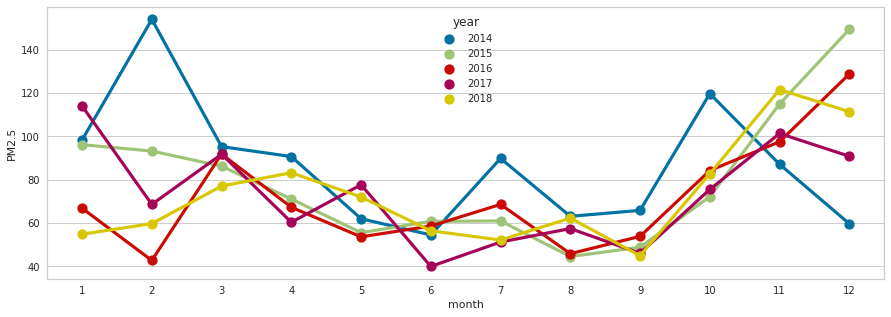

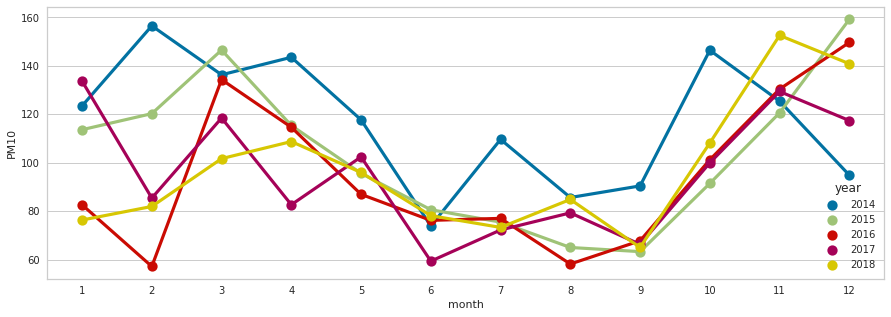

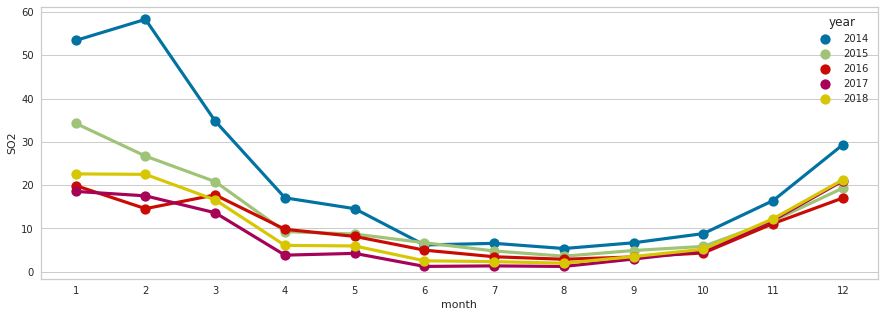

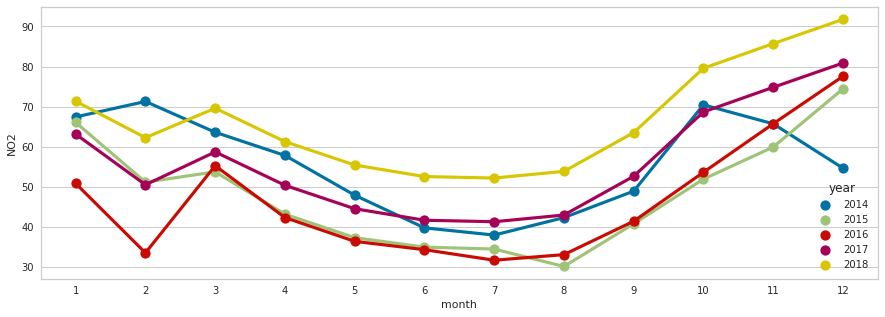

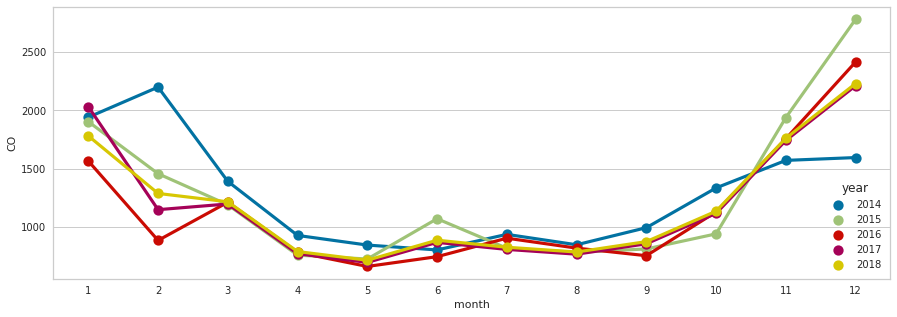

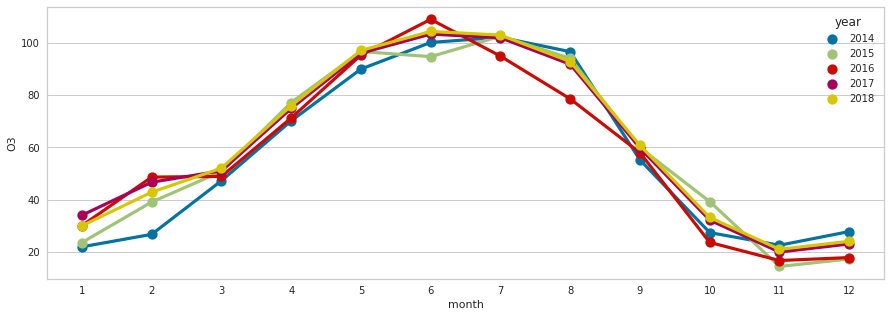

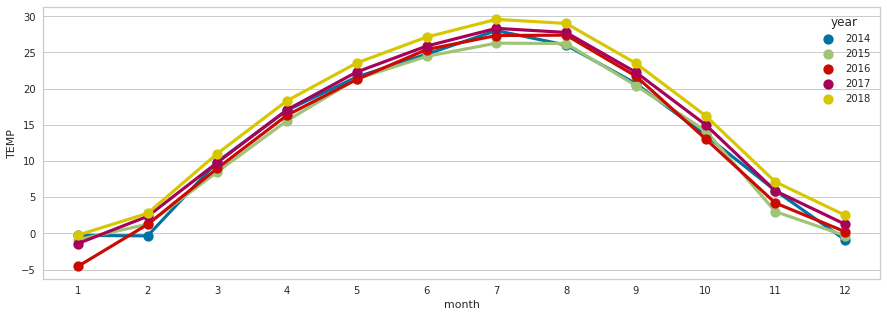

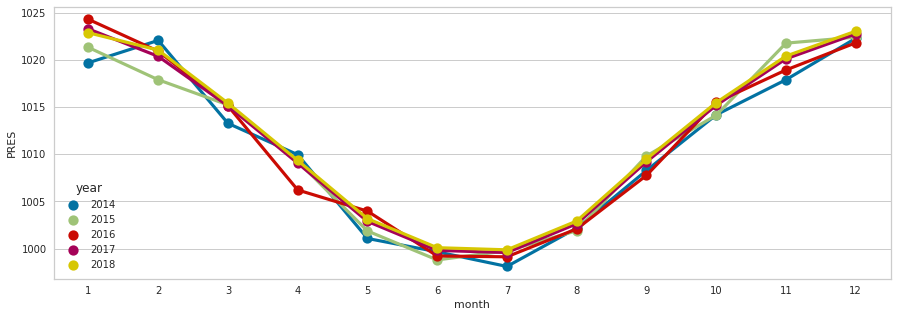

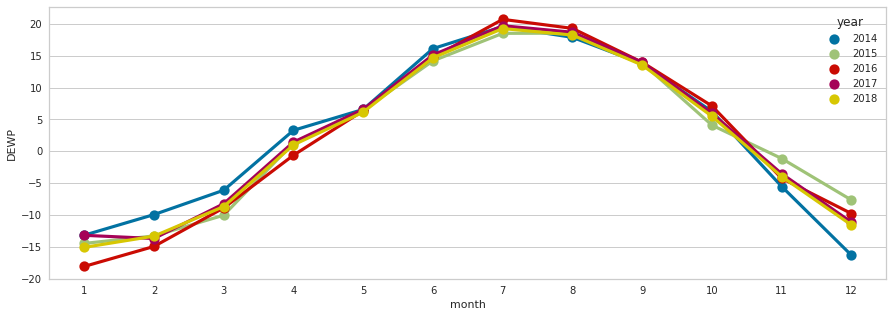

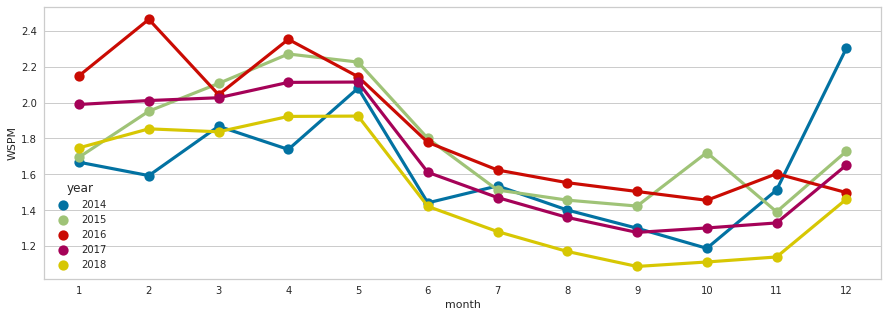

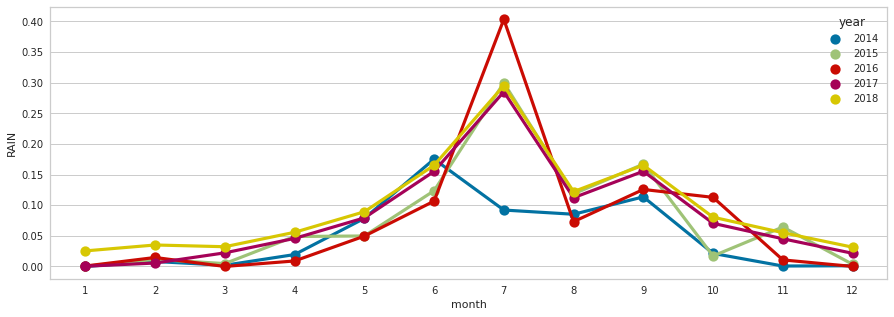

In [84]:
for i in var:    
    f, ax=plt.subplots(figsize=(15, 5))
    sns.pointplot(x='month', y=i, data=time_data, hue="year")

In [64]:
time_pre[var] = sd.inverse_transform(time_pre[var])
time_pre

,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,WSPM,RAIN
38,91.769143,118.430,13.622432,58.719077,1195.418198,51.032459,9.789942,1015.115092,-8.255127,2.027052,0.022206
39,60.408523,82.618,3.837953,50.400798,768.250369,74.936753,17.089793,1009.052573,1.428149,2.112623,0.045762
40,77.696620,102.360,4.247309,44.559345,693.704889,96.068697,22.311824,1002.888120,6.569911,2.114505,0.079276
41,40.006430,59.320,1.235932,41.692521,865.579960,103.365728,25.885943,999.813387,15.116152,1.611546,0.155199
42,51.276708,72.190,1.354873,41.318014,805.222560,101.949458,28.337579,999.587912,19.704026,1.470947,0.285219
43,57.467917,79.260,1.229318,42.990239,764.176417,91.831067,27.772530,1002.634666,18.680640,1.360251,0.112197
44,46.066284,66.240,2.943933,52.655336,853.442241,59.752687,22.269142,1009.193635,13.961403,1.276863,0.155381
45,75.551152,99.910,4.775374,68.688664,1114.660337,32.157210,15.015712,1015.176120,5.920224,1.301687,0.070395
46,101.349317,129.370,11.925594,74.827334,1741.061207,19.941104,5.871871,1020.100054,-3.544507,1.329656,0.045171
47,90.840899,117.370,21.011086,80.877959,2211.143937,23.024351,1.256843,1022.731481,-11.159323,1.651713,0.021468


In [82]:
time_pre['year'] = np.ones(time_pre.shape[0])
time_pre = time_pre.reset_index()
time_pre.drop('index', axis = 1, inplace = True)
for i in range(time_pre.shape[0]):
    if i-10<0:
        time_pre.loc[i, 'year'] = int(2017)
    else:
        time_pre.loc[i, 'year'] = int(2018)
time_pre.to_csv('predict.csv')
time_data.to_csv('former.csv')

In [77]:
int(2017.0)

2017